 ## EDA to Justify Validity of Proposed Feature Transform

### Imports and Reading in Data

In [ ]:
import pandas as pd
import numpy as np
% matplotlib inline

In [2]:
train = pd.read_csv("../data/train.csv")

In [3]:
len(train)

250874

In [4]:
train.head()

,ex_id,user_id,prod_id,rating,label,date,review
0,0,923,0,3.0,1,2014-12-08,The food at snack is a selection of popular Gr...
1,1,924,0,3.0,1,2013-05-16,This little place in Soho is wonderful. I had ...
2,2,925,0,4.0,1,2013-07-01,ordered lunch for 15 from Snack last Friday. ...
3,3,926,0,4.0,1,2011-07-28,This is a beautiful quaint little restaurant o...
4,4,927,0,4.0,1,2010-11-01,Snack is great place for a casual sit down lu...


In [5]:
train.user_id.nunique()

125679

The first thing we want to do is understand how much user repetition there is in our dataset. 

### Exploring Dataset for User Counts

In [6]:
counts = pd.DataFrame(train.user_id.value_counts()).reset_index()
counts.columns = ["id","count"]
counts.head()

,id,count
0,3504,121
1,2980,99
2,3459,84
3,1011,82
4,3324,81


In [7]:
len(counts) == train.user_id.nunique()

True

In [9]:
proportions = []
for i in range(1,11):
    subset = counts[counts['count']>i]
    proportion = (len(subset) / len(counts))*100
    proportions.append(proportion)
    print("The amount of users with more than",i,"review(s) make up",proportion,"% of the dataset")


The amount of users with more than 1 review(s) make up 30.643942106477613 % of the dataset
The amount of users with more than 2 review(s) make up 15.833989767582493 % of the dataset
The amount of users with more than 3 review(s) make up 9.942790760588483 % of the dataset
The amount of users with more than 4 review(s) make up 6.911258046292539 % of the dataset
The amount of users with more than 5 review(s) make up 5.167132138225162 % of the dataset
The amount of users with more than 6 review(s) make up 4.0961497147494805 % of the dataset
The amount of users with more than 7 review(s) make up 3.320363783925716 % of the dataset
The amount of users with more than 8 review(s) make up 2.742701644666173 % of the dataset
The amount of users with more than 9 review(s) make up 2.3313361818601357 % of the dataset
The amount of users with more than 10 review(s) make up 1.994764439564287 % of the dataset


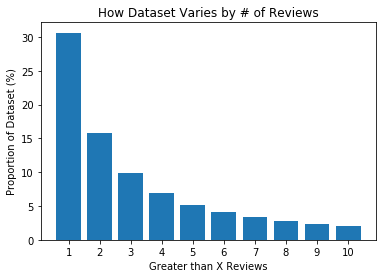

In [15]:
import matplotlib.pyplot as plt
plt.bar(range(1,11),proportions)
plt.ylabel('Proportion of Dataset (%)')
plt.xlabel('Greater than X Reviews')
plt.xticks(range(1,11))
plt.title('How Dataset Varies by # of Reviews')
plt.show()

Now let's see how the label distribution changes as we filter by # of reviews

### Checking Label Distribution Based on Filtering By # of Reviews

In [18]:
train.label.value_counts(normalize=True)

0    0.897084
1    0.102916
Name: label, dtype: float64

In [24]:
train.label.value_counts(normalize=True)[0]

0.8970837950524965

In [35]:
proportion_real = []
for j in [0,1,5,10,15,20]:
    print("-----------------------------------------------------")
    print("LABEL DISTRIBUTION KEEPING ONLY USERS WITH >",j,"REVIEWS")
    copy = train.copy()
    filtered = counts[counts['count']<=j]
    #print("size of counts df reduced from",len(counts),"to",len(filtered))
    toDelete = filtered['id'].tolist()
    print("We are removing",len(toDelete),"users")
    print("Original training size:",len(copy))
    original_size = len(copy)
    copy = copy[~copy['user_id'].isin(toDelete)]
    print("New training size:",len(copy))
    print("We removed",original_size-len(copy),"instances from the dataset")
    print(copy.label.value_counts(normalize=True))
    proportion_real.append(copy.label.value_counts(normalize=True)[0])
    print("-----------------------------------------------------")

-----------------------------------------------------
LABEL DISTRIBUTION KEEPING ONLY USERS WITH > 0 REVIEWS
We are removing 0 users
Original training size: 250874
New training size: 250874
We removed 0 instances from the dataset
0    0.897084
1    0.102916
Name: label, dtype: float64
-----------------------------------------------------
-----------------------------------------------------
LABEL DISTRIBUTION KEEPING ONLY USERS WITH > 1 REVIEWS
We are removing 87166 users
Original training size: 250874
New training size: 163708
We removed 87166 instances from the dataset
0    0.952256
1    0.047744
Name: label, dtype: float64
-----------------------------------------------------
-----------------------------------------------------
LABEL DISTRIBUTION KEEPING ONLY USERS WITH > 5 REVIEWS
We are removing 119185 users
Original training size: 250874
New training size: 78070
We removed 172804 instances from the dataset
0    0.980236
1    0.019764
Name: label, dtype: float64
-----------------

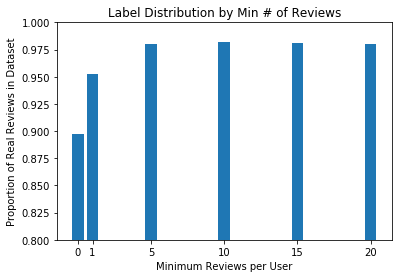

In [47]:
x = [0,1,5,10,15,20]
proportion_real
plt.bar(x,proportion_real)
plt.ylabel('Proportion of Real Reviews in Dataset')
plt.xlabel('Minimum Reviews per User')
plt.xticks(x)
plt.ylim(.8,1)
plt.title('Label Distribution by Min # of Reviews')
plt.show()

### Summary of Results and Appropriate Data Transformation

We found a "splitting criterion" of approximately 5 reviews that changes the label balance significantly. However, implementing this fact alone into our dataset might cause some problems, so an alternative approach to encode this information is discussed below. 

Thinking about the training set at the granularity of a single instance, it would be data leakage to simply add a column that simply gives the total # of reviews given by a user in the set. Luckily, we can use the <i>date </i> column to instead give us the <b> number of reviews by the user up to the date of the current instance </b>, which will circumvent the data leakage issue and still encode what we believe to be (using evidence from above) a feature with fairly significant predictive power. 